In [124]:
import graspologic as gp
import numpy as np
import sklearn as sk
import scipy as sp
from matplotlib import pyplot as plt
import seaborn as sns
from pandas import DataFrame

# Simulating a Realization of a Stochastic Block Model

## Random Network
- Nodes: 100 regions of the brain ($n = 100$)
- Community Assignment Vector: $\vec z$
  + $z_i$: is a node $i$ in community $L$ (Left Hemisphere) or $R$ (Right Hemisphere)?
  + first $35$ nodes: community $L$
  + second $35$ nodes: community $R$
- Block probability matrix: $B$
  + given two nodes, one of which is from community $k$ and the other from community $l$, what is the probability that they are connected?
  + within-community affinity: if two nodes are in the same community, they have a higher probability of being connected ($b_{LL} = b_{RR} = 0.5$)
  + between-community aversion: if two nodes are in different communities, they have a lower probability of being connected ($b_{LR} = b_{RL} = 0.2$)

\begin{align*}
    B &= \begin{bmatrix}
    b_{LL} = 0.5 & b_{LR} = 0.3 \\
    b_{RL} = 0.3 & b_{RR} = 0.5
    \end{bmatrix}
\end{align*}
- Probability matrix: $P$
  + a matrix with $n$ rows and $n$ columns
  + the entry $p_{ij}$ denotes the probability that nodes $i$ and $j$ are connected
  + deduced by using the block probability matrix and the community assignment vector

### Defining the parameters of the random network

In [2]:
# the number of nodes per hemisphere
nl = 35; nr = 35
ns = [nl, nr]

# the community assignment vector
zvec = np.array(["L" for i in range(0, nl)] + ["R" for i in range(0, nr)])


# the block matrix
B = [[0.5, 0.2], [0.2, 0.5]]

# the probability matrix
zvec_ohe = np.vstack([[1,0] for i in range(0, nl)] + [[0, 1] for i in range(0, nr)])
A = gp.simulations.sbm(ns, B, directed=False, loops=False)
P = zvec_ohe @ B @ zvec_ohe.transpose()

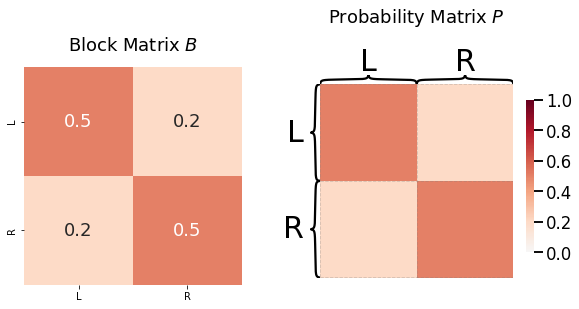

In [3]:
fig, axs = plt.subplots(1,2, figsize=(10,4))
    
gp.plot.heatmap(np.array(B), ax=axs[0], title="Block Matrix $B$", 
                xticklabels=["L", "R"], yticklabels=["L", "R"],
                cbar=False, annot=True, vmin=0, vmax=1)
gp.plot.heatmap(P, ax=axs[1], inner_hier_labels=zvec,
                title="Probability Matrix $P$", vmin=0, vmax=1);

## Realization of the Random Network

- Nodes: 100 regions of the brain ($n = 100$)
- Edges: are two regions of the brain connected by an axonal fiber tract (diffusion connectome)?
  - adjacency matrix: $a_{ij} = 1$ if nodes $i$ and $j$ are connected by an edge, and $a_{ij} = 0$ if nodes $i$ and $j$ are not connected by an edge
- for now, we will assume that we know the community structure ahead of time

### Simulating a realization of the Random Network

In [4]:
A = gp.simulations.sbm(ns, B, directed=False, loops=False)

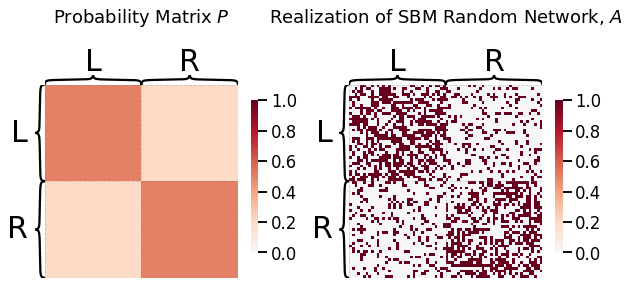

In [5]:
fig, axs = plt.subplots(1,2, figsize=(10,4))

gp.plot.heatmap(P, ax=axs[0], inner_hier_labels=zvec,
                title="Probability Matrix $P$", vmin=0, vmax=1);
gp.plot.heatmap(A, ax=axs[1], inner_hier_labels=zvec,
                title="Realization of SBM Random Network, $A$", vmin=0, vmax=1);

## What does a "real" realization look usually like?

- brain regions are rarely sorted ahead of time for you
  - if you know a "logical" ordering of the nodes that makes the community structure apparent, you are finished!
  - if you don't know a "logical" ordering of the nodes that makes community structure apparent, we need to do a bit more work
- take our simulated network, and randomly reorder the nodes ("shuffle")

In [6]:
# generate a reordering of the n nodes
vtx_perm = np.random.choice(np.sum(ns), size=np.sum(ns), replace=False)

# reorder the adjacency matrix
Aperm = A[tuple([vtx_perm])] [:,vtx_perm]
zperm = zvec[vtx_perm]

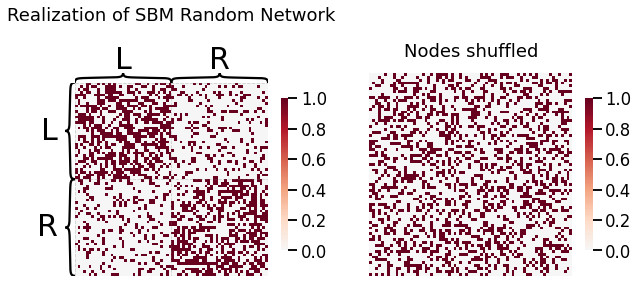

In [7]:
fig, axs = plt.subplots(1,2, figsize=(10,4))

gp.plot.heatmap(A, ax=axs[0], inner_hier_labels=zvec,
                title="Realization of SBM Random Network", vmin=0, vmax=1);
gp.plot.heatmap(Aperm, ax=axs[1],
                title="Nodes shuffled", vmin=0, vmax=1);

- not quite as clear which nodes are in the left or right hemisphere, is it?
- if we want to learn about the community assignment vector or the block matrix, we will need to do some work

# Community Detection

- In what sense do nodes from an SBM "behave" similarly?
- Remember the probability matrix $P$ gives the probabilities $p_{ij}$ of two nodes being connected
  - we will use the notation $\vec p_i$ to denote the vector of probabilities for a given node $i$ being connected with any of the $n$ nodes in the network
- take the probability vectors for nodes $1$ and $2$ (left hemisphere community) and nodes $36$ and $37$ (right hemisphere community) from the "unshuffled" probability matrix

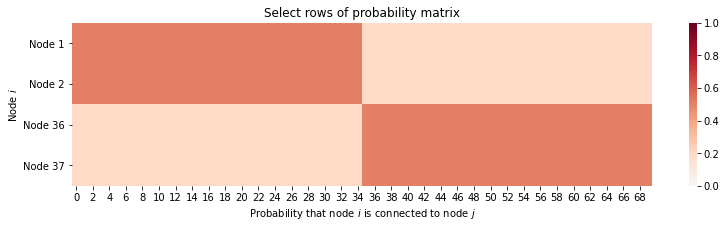

In [8]:
Pleftandright = P[[0,1,35,36],:]
fig, ax = plt.subplots(1,1, figsize=(13, 3))
sns.heatmap(Pleftandright, ax=ax, cmap='RdBu_r', vmin=0, center=0, vmax=1,
           yticklabels=["Node 1", "Node 2", "Node 36", "Node 37"])
ax.set_title("Select rows of probability matrix")
ax.set_ylabel("Node $i$")
ax.set_xlabel("Probability that node $i$ is connected to node $j$");

- What do nodes $1$ and $2$ have in common? Nodes $36$ and $37$?
  + their probability vectors are **identical**
- Why is this a big deal?
  + all nodes within a single community for an SBM have the *exact same* probability vector
- this means that the probability matrix is *low-rank*, and in fact, has a rank of exactly the number of communities in the network
  + rank = how many vectors we would need to express all of the rows in the network
  + if the SBM has $K$ communities, the probability matrix is rank $K$! One probability vector for each community
- Why is this the case?
  + the probability vector of a node is *fully specified* by knowing only the block matrix, the community of the node, and the communities of the other nodes
  + there is nothing unique (in the probability sense) about the nodes *other than* their community assignments
  
## Finding Low-Rank Structure in the Probability Matrix

- when we have data which is low-rank, one way to identify this is by using a "spectral embedding"
  + "spectral": has to do with the eigenvalues/eigenvectors of the data
  + "embedding" (informal): the data possesses a higher-level structure (the probability matrix) which can be described by a lower-level structure (the two unique probability vectors)
- we want a way to identify the low-level structure given the higher-level structure and *nothing else*, which the spectral embedding will let us do
  + "Unsupervised" learning: we don't know anything about the nodes other than the probability matrix
  + See [Book Chapter 6.2]( for more details

### Embedding the Probability Matrix

- The spectral embedding algorithm starts with finding the *singular-value decomposition* of the data (the probability matrix), which for a probability matrix $P$ is identifying the three matrices $U$, $\Sigma$, and $V$ where:
\begin{align*}
    P &= U \Sigma V^\top \\
    &= \begin{bmatrix}
     \uparrow &  & \uparrow \\
      \vec u_1 & ... & \vec u_n \\
     \downarrow &  & \downarrow
    \end{bmatrix}\begin{bmatrix}
    \sigma_{11} & & \\
    & \ddots & \\
    & & \sigma_{nn}
    \end{bmatrix}\begin{bmatrix}
     \uparrow &  & \uparrow \\
      \vec v_1 & ... & \vec v_n \\
     \downarrow &  & \downarrow
    \end{bmatrix}^\top \\
    &= \sum_{i = 1}^n \sigma_{ii}\begin{bmatrix}
    \uparrow \\ \vec u_i \\ \downarrow
    \end{bmatrix}\begin{bmatrix}\leftarrow & \vec v_i^\top & \rightarrow\end{bmatrix}
\end{align*}
  + the columns of $U$ are called the "left singular vectors" of $P$
  + $\Sigma$ is a diagonal matrix, whose entries $\sigma_{ii}$ correspond to the "singular values" of $P$
  + the columns of $V$ are called the "right singular vectors" of $P$
- core idea: first $k$ singular values/vectors are the *best* rank $k$ representation of $P$, which we will call $P_k$
\begin{align*}
    P_k &= \sum_{i = 1}^k \sigma_{ii}\begin{bmatrix}
    \uparrow \\ \vec u_i \\ \downarrow
    \end{bmatrix}\begin{bmatrix}\leftarrow & \vec v_i^\top & \rightarrow\end{bmatrix}
\end{align*}
  + what do we mean by "best"? $P$ and $P_k$ will be maximally similar (the difference, or more specifically, the Frobenius norm between them will be smallest)
  + since $P$ is rank-$2$, if we retain only the top two singular values/vectors, we can recover $P$ perfectly

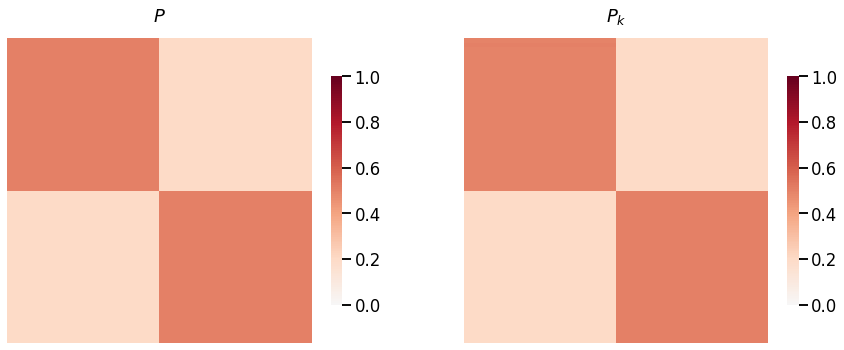

In [79]:
U, s, Vt = np.linalg.svd(P)

# P is rank 2, so the top two singular values/vectors should suffice
k = 2
Pk = U[:,0:k] @ np.diag(s[0:k]) @ Vt[0:k,:]

fig, axs = plt.subplots(1, 2, figsize=(15, 6))
 
gp.plot.heatmap(P, ax=axs[0],
                title="$P$", vmin=0, vmax=1);
gp.plot.heatmap(Pk, ax=axs[1],
                title="$P_k$", vmin=0, vmax=1);

- and we recover the probability matrix perfectly with just two singular values/vectors
- What is really interesting about this representation of the data?
  + As it turns out, due to the structure of $P$ for a SBM, and more generally a RDPG, $\vec u_i = \vec v_i$ for the first $K$ singular vectors where the singular value is non-zero
  + therefore, since $P$ is rank-$K$, we can express $P$ as:
\begin{align*}
    P &= \sum_{i = 1}^K \sigma_{ii} \begin{bmatrix}
     \uparrow \\ \vec u_i \\\downarrow
    \end{bmatrix}\begin{bmatrix}
    \leftarrow & \vec u_i^\top & \rightarrow
    \end{bmatrix} \\
    &= U_k \Sigma_K U_k^\top
\end{align*}
where:
\begin{align*}
    U_k &= \begin{bmatrix}
        \uparrow & & \uparrow \\
        u_1 & ... & u_K \\
        \downarrow & & \downarrow
    \end{bmatrix},\,\,\,
    \Sigma_K = \begin{bmatrix}
        \sigma_{11} & & \\
        & \ddots & \\
        & & \sigma_{KK}
    \end{bmatrix}
\end{align*}
- so all of the information about $P$ is contained by the non-zero singular values and left singular vectors
- Finally, remember that for a square diagonal matrix with positive entries, that:
\begin{align*}
    \Sigma_k &= \begin{bmatrix}
        \sqrt{\sigma_{11}} & & \\
        & \ddots & \\
        & & \sqrt{\sigma_{KK}}
    \end{bmatrix}\begin{bmatrix}
        \sqrt{\sigma_{11}} & & \\
        & \ddots & \\
        & & \sqrt{\sigma_{KK}}
    \end{bmatrix}\\
    &= \sqrt{\Sigma_k}\sqrt{\Sigma_k}^\top
\end{align*}
where:
\begin{align*}
    \sqrt{\Sigma_k} &= \begin{bmatrix}
        \sqrt{\sigma_{11}} & & \\
        & \ddots & \\
        & & \sqrt{\sigma_{KK}}
    \end{bmatrix} = \sqrt{\Sigma_k}^\top
\end{align*}

- When we put this all together, if we let $X = U_k\sqrt{\Sigma_k}$, then we get that $P = XX^\top$!
  + $X = U_k \sqrt{\Sigma_k}$ is a **latent position matrix** for $P$!
- next, let's use what we've learned to define the latent position matrix $X$, and plot it:

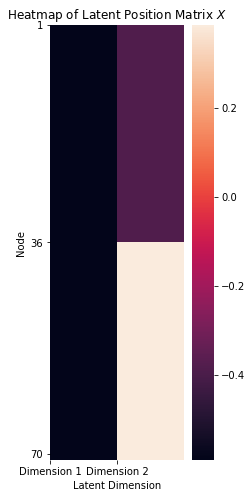

In [80]:
X = U[:,0:k] @ np.diag(np.sqrt(s[0:k]))

def plot_lpm(D, ax=None, title="", xticks=[], xticklabs=[],
            yticks=[], yticklabs=[], cbar=True):
    if ax is None:
        fig, ax = plt.subplots(1,1, figsize=(3,8))
    sns.heatmap(D, ax=ax, cbar=cbar)
    ax.set_xlabel("Latent Dimension")
    ax.set_ylabel("Node")
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabs)
    ax.set_yticks(yticks)
    ax.set_yticklabels(yticklabs)
    ax.set_title(title);

plot_lpm(X, xticks=[0, 1], xticklabs=["Dimension 1", "Dimension 2"],
        yticks=[0, 35, 69], title="Heatmap of Latent Position Matrix $X$",
        yticklabs=["1", "36", "70"])

- remember: rows of the latent position matrix are the latent position vectors for each node
  + for a given community, the latent position vectors are identical!

## Finding a surrogate for the Probability Matrix

- so, if we know can find the latent position matrix, we can just look at which nodes have identical latent position vectors, and then we are done, right?
- In practice, there's a little more work than that
  + Remember, we are given a network with nodes and edges
  + we don't even have the community assignment vector!
  + we have no way to obtain the true probability matrix $P$
- What could we use in place of the true probability matrix?
  + As it turns out, the expected value of the adjacency matrix for an SBM random network *is* the probability matrix
  + what if we just used the adjacency matrix of our realization of the SBM random network?
  + let's try performing a spectral embedding of $A$, assuming we don't know ahead of time that the number of communities is $K$
- we first use the singular value decomposition like we did for $P$, and then we plot out the singular values of $A$ (scree plot)

Text(3, 15, 'Dimension 2')

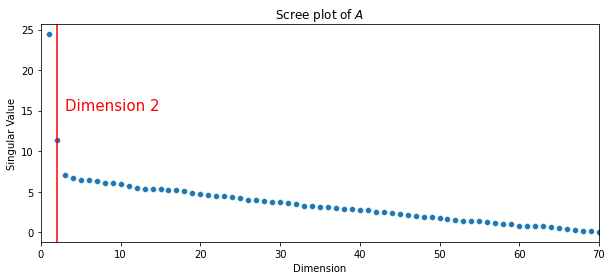

In [214]:
U, s, Vt = np.linalg.svd(A)

fig, ax = plt.subplots(1,1, figsize=(10, 4))
sv_dat = DataFrame({"Singular Value": s, "Dimension": range(1, len(s) + 1)})
sns.scatterplot(data=sv_dat, x="Dimension", y="Singular Value", ax=ax)
ax.set_xlim([0, len(s)])
ax.set_xlabel("Dimension")
ax.set_ylabel("Singular Value")
ax.set_title("Scree plot of $A$")
ax.axvline(x=2, color='r')
ax.text(x=3, y=15, s="Dimension 2", color='r', size=15)

- the singular values fall off rapidly after Dimension 2
  - if we can identify this "elbow" of the scree plot, we can identify the proper number of dimensions we want to embed $A$ into!
- Let's proceed using $k=2$:

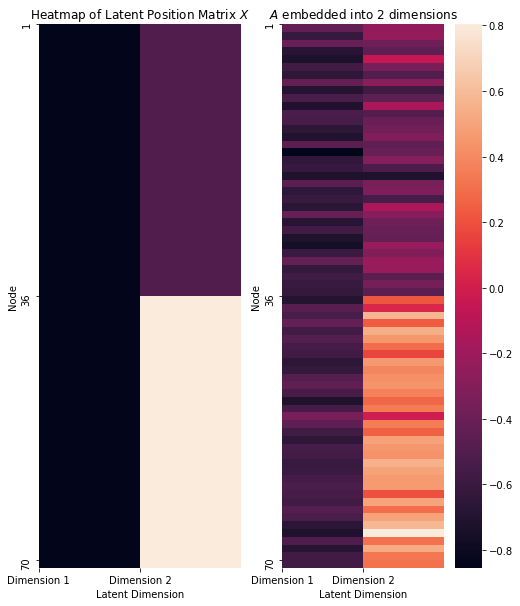

In [82]:
k = 2
Aembedded = U[:,0:k] @ np.diag(np.sqrt(s[0:k]))

fig, axs = plt.subplots(1, 2, figsize=(8, 10))

plot_lpm(X, xticks=[0, 1], ax=axs[0], xticklabs=["Dimension 1", "Dimension 2"],
        yticks=[0, 35, 69], title="Heatmap of Latent Position Matrix $X$",
        yticklabs=["1", "36", "70"], cbar=False)
plot_lpm(Aembedded, ax=axs[1], xticks=[0, 1], xticklabs=["Dimension 1", "Dimension 2"],
        yticks=[0, 35, 69], title="$A$ embedded into $2$ dimensions",
        yticklabs=["1", "36", "70"])

- wow! when we embed $A$ into $2$ dimensions, it doesn't look *identical* to the latent position matrix, but it shares major patterns with it!
  - it looks like the latent positions for the first $35$ nodes (the left hemisphere community) are not identical, but are *similar* in some sense
  - same for right hemisphere
- as it turns out, this spectral embedding of the adjacency matrix is called an *estimate* of the latent position matrix $X$
  - we will denote it with the notation $\hat X$ (the little hat on top of $\hat X$ just means "estimate")
- you'll notice we had to "guess" the number of dimensions to embed into, but there are some algorithms that can help us out here
  - [Zhu/Ghodsi (2012)](https://sas.uwaterloo.ca/~m3zhu/papers/csda2006b.pdf)
  - we can just use `graspologic`'s `AdjacencySpectralEmbed()` class to help us out here, which implements this technique

In [85]:
ase = gp.embed.AdjacencySpectralEmbed()
ase = ase.fit(A)
Xhat = ase.latent_left_

- next, what we're going to do is look at the estimate of the latent position matrix another way, called a pairplot
  - a pairplot allows us to look at all pairs of dimensions for a matrix
  - if the matrix has $2$ dimensions, then the pairplot is a $2 \times 2$ series of tiles
  - the subplots $(k, l)$ are scatter plots, where the points are the pairs $(\hat x_{ik}, \hat x_{il})$ from the estimate of the latent position matrix $\hat X$ for each node $i$ in the network

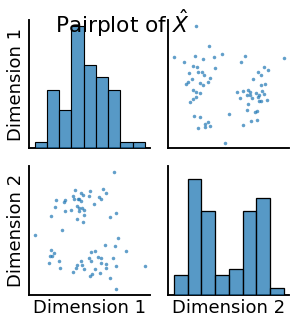

In [89]:
gp.plot.pairplot(Xhat, title="Pairplot of $\hat X$")

- Notice that in dimension $2$, we see that there are two "blobs" of nodes
- Next, we're going to cheat a little bit and take a peek at the true communities of the nodes

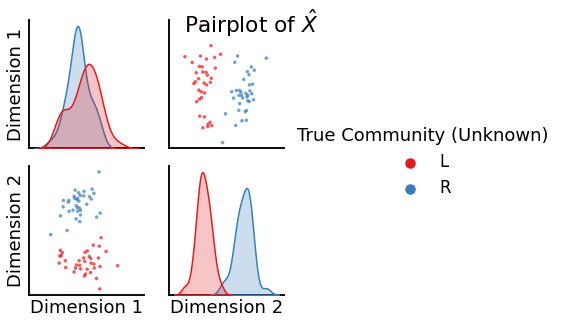

In [92]:
gp.plot.pairplot(Xhat, labels=zvec, title="Pairplot of $\hat X$", 
                 legend_name="True Community (Unknown)")

- Wow! These blobs happen to be the two different communities! Miraculous, right?
  + sadly, we don't know these community labels ahead of time
  + we need a technique which will identify "blobs" of similar points

## Clustering with Unsupervised Learning

- Given the estimates of the latent positions for each of the $n$ nodes, $\hat {\vec x}_i$, predict the community $\hat z_i$ for the node $i$

### K-Means

- without knowing which points are in which community, attempt to find reasonable "guesses" of the centers of the two blobs
  + we will call these centers $\vec \mu_1$ and $\vec\mu_2$
  + if a point is closest to center $\vec \mu_1$, predict the point is in community $1$
  + if a point is closest to center $\vec \mu_2$, predict the point is in community $2$
- First, we need a definition of "close", for which we will use the squared Euclidean distance, which if $\hat{\vec x}_i$ and $\vec\mu_k$ each have $K$ dimensions (the number of communities), is defined as:
\begin{align*}
    ||\hat{\vec x}_i - \mu_k||^2 = \sum_{l = 1}^K (\hat x_{il} - \mu_{kl})^2
\end{align*}

- We do this by first initializing two centers in the dataset. These centers can be chosen randomly, or using some heuristics. We'll just arbitrarily put one in the bottom right, and another in the bottom left. The centers will be shown in orange:

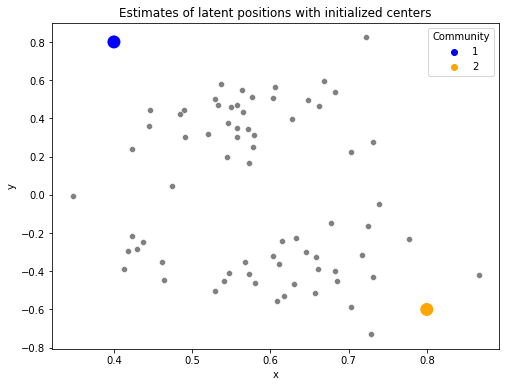

In [189]:
centers = np.array([[.4, .8], [.8, -.6]])

palette = {"1": "blue", "2": "orange"}
data = DataFrame({"x": Xhat[:,0], "y": Xhat[:,1]})
datcenters = DataFrame({"x": centers[:,0], "y": centers[:,1], "Community": ["1","2"]})
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
sns.scatterplot(data=data, x="x", y="y", color="gray", ax=ax)
sns.scatterplot(data=datcenters, x="x", y="y", hue="Community",
                palette=palette, ax=ax, s=200)
ax.set_title("Estimates of latent positions with initialized centers");

Next, what we do is we identify which points are "closest" to each center. We do this by computing the distance between each estimate of a latent position and the two centers, and then deciding which is the smallest:

In [190]:
closest_center = []
for i in range(0, Xhat.shape[0]):
    dists = [np.linalg.norm(Xhat[i,:] - centers[k,:])**2 for k in range(0, 2)]
    closest_center.append(np.argmin(dists) + 1)
data["Closest Center"] = np.array(closest_center).astype(str)

Let's take a look at what this looks like graphically:

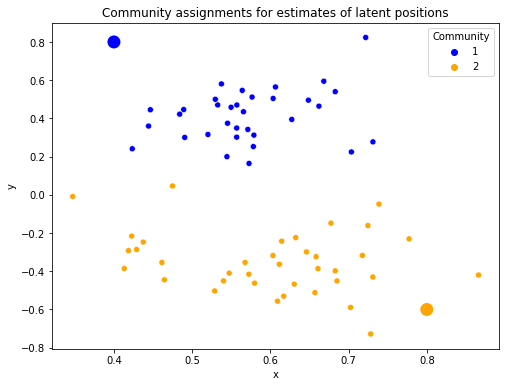

In [191]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
sns.scatterplot(data=data, x="x", y="y", hue="Closest Center", palette=palette,
                ax=ax, legend=False)
sns.scatterplot(data=datcenters, x="x", y="y", hue="Community", ax=ax, 
                palette=palette, s=200)
ax.set_title("Community assignments for estimates of latent positions");

- Not bad! It looks like we have done a pretty good job of grabbing the two "blobs" in our dataset
- The next step is we update the centers
  + We do this by looking at all of the points which are "assigned" to a particular community, and then we compute the middle of them
- This moves our centers like this:

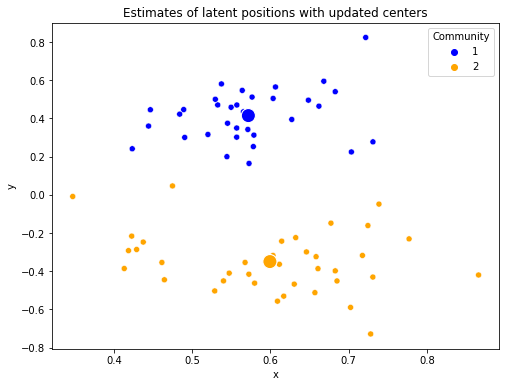

In [193]:
centers = np.array([np.mean(Xhat[data["Closest Center"] == str(k+1),:], axis=0) for k in range(0, 2)])

datcenters = DataFrame({"x": centers[:,0], "y": centers[:,1], "Community": ["1","2"]})

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
sns.scatterplot(data=data, x="x", y="y", hue="Closest Center", palette=palette,
                ax=ax, legend=False)
sns.scatterplot(data=datcenters, x="x", y="y", hue="Community", ax=ax, 
                palette=palette, s=200)
ax.set_title("Estimates of latent positions with updated centers");

- Then, we pretend the estimates of latent positions have not been assigned a community yet:

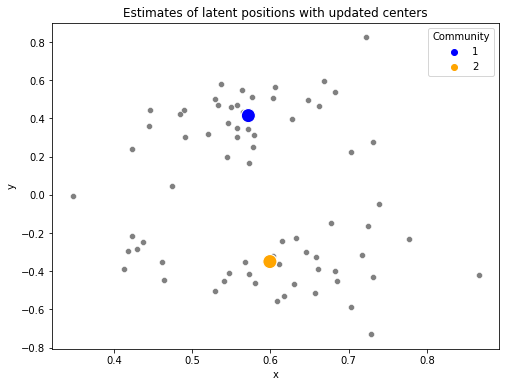

In [194]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
sns.scatterplot(data=data, x="x", y="y", color="gray", ax=ax)
sns.scatterplot(data=datcenters, x="x", y="y", hue="Community",
                palette=palette, ax=ax, s=200)
ax.set_title("Estimates of latent positions with updated centers");

- And we keep repeating the process until our centers stop changing very much
- We can automate this whole process using `sklearn`'s `KMeans` function. After we do that, we plot our estimates of the latent positions, along with their predicted communities:

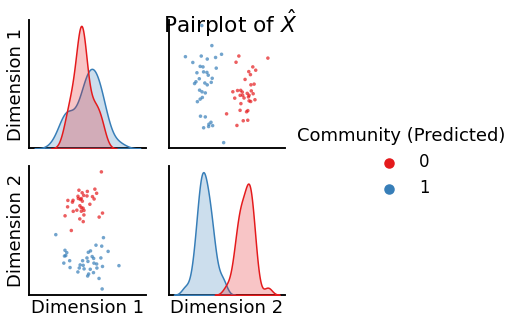

In [199]:
from sklearn.cluster import KMeans

labels_kmeans = KMeans(n_clusters = 2).fit_predict(Xhat)
gp.plot.pairplot(Xhat, labels=labels_kmeans, title="Pairplot of $\hat X$",
                 legend_name="Community (Predicted)")

- It looks like we've done a good job of capturing the two "blobs" in the estimated latent positions

### Evaluation of K-Means clustering

- To determine just how well (or not!) we did with our clustering, we need a performance evaluation metric
  + At a high level, we want this evaluation metric to ignore the fact that K-Means gave us predictions of 1s and 0s, which are different from our true labels of "Left" and "Right"

#### Adjusted Rand Index (ARI)

- for each true label (Left/Right), compute the number of points which are assigned to each of the predicted labels (0 or 1), and organize them in a contingency table

| True Label | Prediction of $0$ | Prediction of $1$ |
| --- | --- | --- |
| Left | $n_{L0}$ | $n_{L1}$ |
| Right | $n_{R0}$ | $n_{R1}$|

- Success: two items with the same true label (left or right) both fall into the same predicted label (0 or 1)
- Failure: two items with the same true label (left or right) fall into different predicted labels
- Count the number of times we get a success divided by the number of times we have a failure
- Adjusted: normalize by the numbers of successes/failures we would expect by random chance (if the points were just randomly assigned predictions of $0$ or $1$)
- Produces a value between $-1$ (low agreement) and $1$ (high agreement)

In [201]:
from sklearn.metrics import adjusted_rand_score

ari_kmeans = adjusted_rand_score(zvec, labels_kmeans)
print("ARI: {:.3f}".format(ari_kmeans))

ARI: 0.943


- The ARI is close to $1$, which means our clustering did a good job!

## What if we don't know the number of communities ahead of time?

- In the above clustering, we knew that the number of clusters we wanted to find was $2$, since we knew we wanted to find communities for a two community SBM
  + when you are exploring (potentially unknown) communities, you won't have a number to find ahead of time
  + need to choose on the basis of reasonable heuristics what a "good" number of communities to detect is
- For this reason, we introduce a new performance metric
  
### The silhouette score

- Choose a distance metric (we will use the Euclidean distance)
- Let $C_k$ denote the set of nodes which are assigned to community $k$
  + total number of nodes in community $k$ will be denoted $n_k$
- For each node $i$ in community $k$, compute the average distance between the estimate of the latent position for node $i$ and all of the other nodes which are assigned to the same community as node $i$
  + "How dissimilar is node $i$ from the other nodes in the same community $k$?"

\begin{align*}
    a_i &= \frac{1}{n_k - 1}\sum_{j \in C_k, i \neq j} ||\hat{\vec x}_i - \hat{\vec x}_j||
\end{align*}

- Next, for each node $i$, we compute the average distance between the estimate of the latent position of node $i$ and all of the other nodes which are assigned to a different community $l$, where $l \neq k$
  + "How dissimiar is node $i$ from the nodes in community $l$?"
\begin{align*}
    b_{il} = \frac{1}{n_l} \sum_{j \in C_l} ||\hat{\vec x}_i - \hat{\vec x}_j||
\end{align*}

- Finally, we find the dissimilarity associated with the community that node $i$ is the least dissimilar from, using:
\begin{align*}
    d_i = \min_{k \neq l} b_{il}
\end{align*}

- We define the *silhouette* of node $i$ in community $k$, using:
\begin{align*}
    s_i &= \begin{cases}
        \frac{d_i - a_i}{\max(a_i, d_i)} & n_k > 1 \\
        0 & n_k = 1
    \end{cases}
\end{align*}
  + This quantity indicates how much more similar the node $i$ is to the cluster it was assigned to than the best possible alternative cluster it could have been assigned to
  + $s_i$ near $1$: node $i$ is much more similar to points in its cluster than the best possible alternative cluster
  + $s_i$ near $-1$: node $i$ is more similar to points in a neighboring cluster

- Finally, if the dataset has $K$ communities in total, we define the Silhouette Score to be the average silhouette of all the nodes:
\begin{align*}
    S_K &= \frac{1}{n}\sum_{i = 1}^n s_i
\end{align*}

### Using the silhouette score to deduce an appropriate number of communities

- Now that we have the silhouette score, deducing an appropriate number of communities is relatively easy
  - For each possible number of communities $K$, cluster the estimate of the latent positions to predict communities, and then identify the Silhouette Score associated with the community assignments, $S_K$
  - Find the number of communities which minimizes the Silhouette Score, and call this the estimate of the number of communities $\hat K$:
\begin{align*}
    \hat K &= \text{arg} \min_{K} S_K
\end{align*}
- All of this is automated for us with `graspologic`'s `KMeansCluster` function:

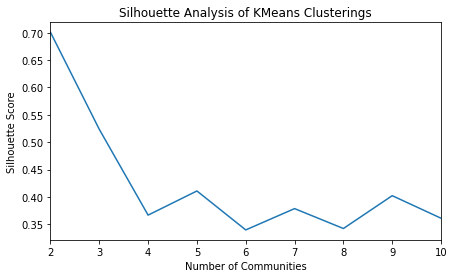

In [213]:
Kmax = 10  # the maximum number of clusters we think could exist
kclust_ = gp.cluster.KMeansCluster(max_clusters = Kmax)
kclust_.fit_predict(Xhat)

nclusters = range(2, Kmax + 1)
silhouette = kclust_.silhouette_

silhouette_df = DataFrame({"Number of Communities": nclusters, "Silhouette Score": silhouette})

fig, ax = plt.subplots(1,1,figsize=(7, 4))
sns.lineplot(data=silhouette_df,ax=ax, x="Number of Communities",
             y="Silhouette Score");
ax.set_title("Silhouette Analysis of KMeans Clusterings")
ax.set_xlim([2, 10]);

- As we can see, the silhouette analysis reveals the optimal number of communities to be $2$, since this produced the highest silhouette score
  - we have "detected" two communities in our network